In [1]:
from IPython.display import HTML, Image
HTML('''
    <script src='https://ajax.googleapis.com/ajax/libs/jquery/3.6.1/jquery.min.js'></script>
    <script>
    code_show=false;
    function code_toggle() {
        if (code_show){
        $('div.jp-Editor').show();
        } else {
        $('div.jp-Editor').hide();
    }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
    </script>
    <form action='javascript:code_toggle()'><input type='submit' value='Click here to toggle on/off the raw code.'></form>''')


In [119]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

plt.style.use('style/advocate.mplstyle')
%matplotlib inline
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [120]:
rh = pd.read_csv('raw data/Road Home Closed with Jurisdiction Census Info 7-19-2022 with ARS.csv')



In [121]:
# Exclude the row that includes the sum for each field
rh = rh[rh['Census Block'].notnull()]

In [122]:
rh.columns

Index(['Structure Type', 'GIS City', 'GIS State', 'GIS Zip', 'PARISH',
       'Closing Option', 'TOTAL_CLOSING_AMOUNT', 'Total CG Amount',
       'Total ACG Amunt', 'Total Elevation Amount', 'Total IMM Amount',
       'NOLA Planning District Number', 'NOLA Planning District Name',
       'NOLA Neighborhood Number', 'NOLA Neighborhood Name', 'STFID',
       'Census Block', 'Block Group', 'Census Track', 'ORL_CD_NUM',
       'ORL_CD_NAM', 'Current Damage Assessment',
       'Current Damage Assessment - Type 1',
       'Current Damage Assessment - Type 2', 'Damage Type 1 or 2',
       'Current PSV', 'Current Total DOB Amount (no Legal Fees removed)',
       'Current Legal Fees', 'Closing Damage Assessment', 'PSV at Closing',
       'Closed file - PSV Option 1 With No ACG -excluding Sold Home, Inelig, Deceased and files closed with RHEI & IMM only -23,912',
       'Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only',
       'Closed with Approved Un

In [123]:
print('Basic stats:')
print(f"Number of records: {len(rh):,.0f}")
print(f"Number of non-null records: {len(rh.dropna(axis=1)):,.0f}")
print(f"Number of records where CG>0 and DA>0: {len(rh[(rh['Current Damage Assessment']>0) & (rh['Total CG Amount']>0)]):,.0f}")
print(f"Total grant amount: ${rh['TOTAL_CLOSING_AMOUNT'].sum():,.2f}")
print(f"Total damage assessment: ${rh['Current Damage Assessment'].sum():,.2f}")
print(f"Total CG amount: ${rh['Total CG Amount'].sum():,.2f}")
print(f"Total ACG amount: ${rh['Total ACG Amunt'].sum():,.2f}")
print(f"Total elevation amount: ${rh['Total Elevation Amount'].sum():,.2f}")
print(f"Total IMM amount: ${rh['Total IMM Amount'].sum():,.2f}")
print(f"Total DOB amount: ${rh['Current Total DOB Amount (no Legal Fees removed)'].sum():,.2f}")
print(f"Total legal fees: ${rh['Current Legal Fees'].sum():,.2f}")


Basic stats:
Number of records: 130,053
Number of non-null records: 130,053
Number of records where CG>0 and DA>0: 122,668
Total grant amount: $9,030,446,583.33
Total damage assessment: $18,313,314,464.07
Total CG amount: $5,767,978,729.72
Total ACG amount: $2,126,950,433.45
Total elevation amount: $942,775,529.66
Total IMM amount: $192,741,890.50
Total DOB amount: $6,026,881,082.18
Total legal fees: $38,267,095.46


In [124]:
pipeline = pd.DataFrame(index=['Calcasieu', 'Jefferson', 'Orleans', 'St. Bernard', 'St. Tammany'], columns=['Pipeline Option 1 count'], data=[12717, 25128, 41638, 7848, 10939])
print('Comparison of dataset and pipeline Option 1 counts for top 5 parishes by number of properties that participated in Road Home')
dataset_pipeline_compare = pd.concat([
                                        rh[
                                            (rh['PARISH'].isin(['Orleans', 'Jefferson', 'Calcasieu', 'St. Tammany', 'St. Bernard'])) & 
                                            (rh['Closing Option']==1)
                                            ]
                                            .groupby('PARISH')
                                            .agg(
                                                {
                                                    'Total CG Amount' : 'count', 
                                                    }
                                                )
                                            .rename(columns = {'Total CG Amount' : 'Dataset Option 1 count'})
                                        ,
                                        pipeline
                                        ],
                                        axis=1
                                    )
dataset_pipeline_compare['Difference'] = dataset_pipeline_compare['Dataset Option 1 count']-dataset_pipeline_compare['Pipeline Option 1 count']
display(dataset_pipeline_compare)

Comparison of dataset and pipeline Option 1 counts for top 5 parishes by number of properties that participated in Road Home


,Dataset Option 1 count,Pipeline Option 1 count,Difference
Calcasieu,12702,12717,-15
Jefferson,25148,25128,20
Orleans,41614,41638,-24
St. Bernard,7852,7848,4
St. Tammany,10944,10939,5


Setting up rh_clean, which will exclude records from the analysis. The criteria for inclusion are:
- rh['Current Damage Assessment']>0 : Exclude records with no recorded damage. This excludes properties that did not have damage recorded.
- rh['Total CG Amount']>0 : Exclude records with no Compensation Grants. This excludes properties that may have damage recorded but did not get repair/rebuilding grants.
- rh['Closing Option']==1 : Exclude any properties whose owners chose Option 2 (sell property to the state and buy another home in Louisiana) and Option 3 (sell property to the state and do not buy a home in Louisiana).
- rh['Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only']=='N' : This flag was created by the state. This includes the three criteria listed above as well as edge cases that might skew the data. Earlier criteria are included to ensure all matching properties are excluded.
- rh['Closed with Unmet Needs (Y/N)']=='N' : Exclude properties that got money through the Unmet Needs program. These properties received additional money from the state for problems outside of their control (such as contractors taking money but not doing work). The state did not provide specific Unmet Needs amounts, so these properties must be excluded entirely. 
- rh['ARS File (Yes/No)=='N'] : Exclude properties that are subject to a lawsuit between the state and its contractor (ICF) over incorrect grant values


In [125]:
rh_clean = rh[
    (rh['Current Damage Assessment']>0) & 
    (rh['Total CG Amount']>0) & 
    (rh['Closing Option']==1) &
    (rh['Closed File - Option 2/3, Sold Home, Ineligible, Deceased, and Closed with RHEI and IMM Only']=='N') &
    (rh['Closed with Approved Unmet Needs (Y/N)']=='N') &
    (rh['ARS File (Yes/No)']=='N')
    ].copy()

In [126]:
print('Basic stats (with non-relevant records excluded):')
print(f"Number of records: {len(rh_clean):,.0f}")
print(f"Number of non-null records: {len(rh_clean.dropna(axis=1)):,.0f}")
print(f"Number of records where CG>0 and DA>0: {len(rh_clean[(rh_clean['Current Damage Assessment']>0) & (rh_clean['Total CG Amount']>0)]):,.0f}")
print(f"Total damage assessment: ${rh_clean['Current Damage Assessment'].sum():,.2f}")
print(f"Total grant amount: ${rh_clean['TOTAL_CLOSING_AMOUNT'].sum():,.2f}")
print(f"Total CG amount: ${rh_clean['Total CG Amount'].sum():,.2f}")
print(f"Total ACG amount: ${rh_clean['Total ACG Amunt'].sum():,.2f}")
print(f"Total elevation amount: ${rh_clean['Total Elevation Amount'].sum():,.2f}")
print(f"Total IMM amount: ${rh_clean['Total IMM Amount'].sum():,.2f}")
print(f"Total DOB amount: ${rh_clean['Current Total DOB Amount (no Legal Fees removed)'].sum():,.2f}")
print(f"Total legal fees: ${rh_clean['Current Legal Fees'].sum():,.2f}")


Basic stats (with non-relevant records excluded):
Number of records: 93,490
Number of non-null records: 93,490
Number of records where CG>0 and DA>0: 93,490
Total damage assessment: $12,378,566,488.50
Total grant amount: $6,438,287,932.89
Total CG amount: $4,127,228,647.02
Total ACG amount: $1,517,663,016.58
Total elevation amount: $636,665,696.75
Total IMM amount: $156,730,572.54
Total DOB amount: $3,910,966,433.69
Total legal fees: $26,839,981.72


In some cases, the DOB amount increased after the initial grants were awarded. In those cases, the combined CG/ACG amount in these records was not adjusted to reflect the increase. However, the state sought to claw back the money from CG/ACG, which now represents an overpayment.

As a result, we have to adjust the combined CG/ACG values so they reflect the appropriate amount actually provided to the property owner.

FOR TESTING PURPOSES, ONLY CG IS CURRENTLY BEING ADJUSTED. TO-DO: DEVELOP FORMULA TO ADJUST CG OR ACG AS APPROPRIATE.

In [127]:
rh_clean['Current DOB (no legal fees)'] = rh_clean['Current Total DOB Amount (no Legal Fees removed)'].fillna(0)-rh_clean['Current Legal Fees'].fillna(0)

rh_clean['dob_difference'] = rh_clean['Current DOB (no legal fees)'] - rh_clean['Closing Total DOB Amount']
print(f"DOB increase : {len(rh_clean[rh_clean['dob_difference']>0]):,.0f}")
print(f"DOB decrease : {len(rh_clean[rh_clean['dob_difference']<0]):,.0f}")

DOB increase : 12,819
DOB decrease : 14,105


According to Jeff Haley, DOB could be adjusted up or down through the process so both increases and decreases should be accounted for.

In [128]:
rh_clean.loc[rh_clean['dob_difference']>0, 'Total CG Amount'] = rh_clean['Total CG Amount']-rh_clean['dob_difference']

Road Home records need to have legal fees subtracted from the Duplication of Benefits amount because legal fees were covered by the Compensation Grants. Create new field to reflect this amount ('DOB (no legal fees)').

Create 'compensation" field to sum CG, ACG and DOB fields.

In [131]:
rh_clean['compensation'] = rh_clean['Total CG Amount'].fillna(0)+rh_clean['Total ACG Amunt'].fillna(0)+rh_clean['Current DOB (no legal fees)'].fillna(0)

In [132]:
rh_clean[(rh_clean['compensation']>rh_clean['Current Damage Assessment'])][['Census Block', 'Total CG Amount', 'Total ACG Amunt', 'compensation', 'Current Damage Assessment', 'Closing Damage Assessment', 'Current Total DOB Amount (no Legal Fees removed)', 'Closing Total DOB Amount']].head(50)

,Census Block,Total CG Amount,Total ACG Amunt,compensation,Current Damage Assessment,Closing Damage Assessment,Current Total DOB Amount (no Legal Fees removed),Closing Total DOB Amount
7,"220,510,278,052,010.00","6,358.26",0.00,"27,263.19","27,263.19","27,263.19","20,904.93","20,904.93"
10,"220,510,226,001,005.00","29,571.80",0.00,"60,369.21","60,369.21","60,369.21","35,446.41","26,153.41"
11,"220,510,275,025,004.00","21,984.56","9,421.95","31,406.51","31,406.51","31,406.51",0.00,"8,414.42"
75,"220,510,217,006,003.00","12,240.60",0.00,"72,944.40","72,944.40","72,944.40","60,703.80","66,387.58"
99,"220,510,234,001,020.00","10,224.08",0.00,"99,495.54","99,495.54","99,495.54","89,271.46","89,271.46"
100,"220,510,248,005,013.00","97,756.69",0.00,"176,123.40","176,123.40","176,123.40","78,366.71","78,366.71"
109,"220,710,025,043,011.00","45,230.91",0.00,"73,457.26","73,457.26","73,457.26","28,226.35","28,226.35"
111,"221,030,408,033,024.00","70,444.97",0.00,"77,618.29","77,618.29","77,618.29","7,173.32","7,173.32"
122,"220,510,214,001,015.00","9,607.47",0.00,"27,405.51","27,405.51","27,405.51","17,798.04","17,798.04"
139,"221,030,407,082,027.00","17,243.18",0.00,"110,475.54","110,475.54","110,475.54","93,232.36","93,232.36"


In [133]:
len(rh_clean[(rh_clean['compensation']>rh_clean['Current Damage Assessment']+1)])

1676

Uncomment next line to filter out records where compensation is higher than damage

In [134]:
rh_clean = rh_clean[(rh_clean['compensation']<=rh_clean['Current Damage Assessment']+1)]


Aggregate rh_clean to blocks and rename fields to match names used in past analyses.

In [137]:
rh_blocks = (rh_clean
            .groupby('Census Block')
            .agg({
                'Closing Option' : 'count', 
                'TOTAL_CLOSING_AMOUNT' : 'sum', 
                'Total CG Amount' : 'sum',
                'Total ACG Amunt' : 'sum',
                'Total Elevation Amount' : 'sum',
                'Total IMM Amount' : 'sum',
                'Current Damage Assessment' : 'sum',
                'Current Damage Assessment - Type 1' : 'sum',
                'Current Damage Assessment - Type 2' : 'sum',
                'Current PSV' : 'sum',
                'Current DOB (no legal fees)' : 'sum'
                })
            )

rh_blocks = rh_blocks.reset_index().rename(columns = {
                    'Census Block' : 'GEOID',
                    'Total CG Amount' : 'compensation_sum',
                    'Total ACG Amunt' : 'additional_compensation_sum',
                    'Total Elevation Amount' : 'elevation_sum',
                    'Total IMM Amount' : 'mitigation_sum',
                    'TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
                    'Closing Option' : 'all_grants_count',
                    'Current PSV' : 'pre_storm_value_sum',
                    'Current Damage Assessment' : 'damage_sum',
                    'Current DOB (no legal fees)' : 'insurance_sum',
                    'Current Damage Assessment - Type 1' : 'damage_type_1',
                    'Current Damage Assessment - Type 2' : 'damage_type_2'

})
rh_blocks['GEOID'] = rh_blocks['GEOID'].astype(str)

Import flooding statistics by Census block and generate list of GEOIDs with greater than 3 feet of flooding for filtering. NOTE: This is no longer being used in the analysis but has been left in this notebook in case it becomes relevant in the future.


In [138]:
# flood_blocks = gpd.read_file('shapefiles/flood_blocks_all/flood_blocks_all.shp')
# flood_blocks = flood_blocks[['BLKIDFP00', 'flood_mean', 'flood_medi', 'flood_min', 'flood_max']]
# flood_blocks = flood_blocks.rename(columns = {'BLKIDFP00' : 'GEOID', 'flood_medi' : 'flood_median'})
# flood_blocks['GEOID'] = flood_blocks['GEOID'].astype(str)
# flood_blocks_GT3 = flood_blocks[flood_blocks['flood_min'] > 3]['GEOID'].to_list()


Import block-level race and household data, rename fields and create GEOID field for block-level data. This is also no longer used in the analysis because the race and household data will come from block group-level IPUMS. However, this step is being left in should we need it in the future.

In [139]:
# blocks_race = pd.read_csv('raw data/2000-La-HispanicRaceByBlock.csv', skiprows=[0])

# # Rename relevant columns for easy reference
# blocks_race = blocks_race.rename(
#     columns = {
#         'Total!!Hispanic or Latino' : 'Hispanic',
#         'Total!!Not Hispanic or Latino!!Population of one race!!White alone' : 'White',
#         'Total!!Not Hispanic or Latino!!Population of one race!!Black or African American alone' : 'Black',
#         'Total!!Not Hispanic or Latino!!Population of one race!!American Indian and Alaska Native alone' : 'Indigenous',
#         'Total!!Not Hispanic or Latino!!Population of one race!!Asian alone' : 'Asian',
#         'Total!!Not Hispanic or Latino!!Population of one race!!Native Hawaiian and Other Pacific Islander alone' : 'NHOPI',
#         'Total!!Not Hispanic or Latino!!Population of one race!!Some other race alone' : 'Other',
#         'Total!!Not Hispanic or Latino!!Population of two or more races' : 'Multiracial'
#     })
# blocks_race = blocks_race[['Total', 'White', 'Black', 'Hispanic', 'Indigenous', 'Asian', 'NHOPI', 'Other', 'Multiracial', 'Geography']]

# # Generate GEOID field
# blocks_race['GEOID'] = blocks_race['Geography'].apply(lambda x: x.split('US')[1])

# # Import household statistics based on 2000 Census
# households = pd.read_csv('raw data/2000-La-TenureByHouseholderRaceByBlock.csv', skiprows=[0])
# households['GEOID'] = households['Geography'].apply(lambda x: x.split('US')[1])
# households = households[['GEOID', 'Total', 'Total!!Owner occupied', 'Total!!Owner occupied!!Householder who is Black or African American alone']]
# households = households.rename(
#     columns =
#         {
#             'Total' : 'households_2000_total',
#             'Total!!Owner occupied' : 'households_2000_owner_occupied',
#             'Total!!Owner occupied!!Householder who is Black or African American alone' : 'households_2000_owner_occupied_black'
#         })



Import block group-level IPUMS data on race, income and households. NOTE: These fields are required for the rest of the analysis

In [140]:
income = pd.read_csv('processed data/rh_block_groups_all_LA_income_poverty_race_table_3.csv')
income['GEOID'] = income['GEOID'].astype(str)
income = income.rename(columns=
                        {"HAK001": "total_pop",
                        "HA2001":"total_households",
                        "HAQ001": "not_hispanic",
                        "HAQ002": "hispanic",
                        "HAR001":"not_hispanic_white",
                        "HAR002":"not_hispanic_black",
                        "HAR003":"not_hispanic_native",
                        "HAR004":"not_hispanic_asian",
                        "HAR005":"not_hispanic_pacific_islander",
                        "HAR006":"not_hispanic_other",
                        "HAR007":"not_hispanic_two_or_more",
                        "HAR008":"hispanic_white",
                        "HAR009":"hispanic_black",
                        "HAR010":"hispanic_native",
                        "HAR011":"hispanic_asian",
                        "HAR012":"hispanic_pacific_islander",
                        "HAR013":"hispanic_other",
                        "HAR014":"hispanic_two_or_more",
                        "HF5001":"hh_lt_10000",
                        "HF5002":"hh_10000_14999",
                        "HF5003":"hh_15000_19999",
                        "HF5004":"hh_20000_24999",
                        "HF5005":"hh_25000_29999",
                        "HF5006":"hh_30000_34999",
                        "HF5007":"hh_35000_39999",
                        "HF5008":"hh_40000_44999",
                        "HF5009":"hh_45000_49999",
                        "HF5010":"hh_50000_59999",
                        "HF5011":"hh_60000_74999",
                        "HF5012":"hh_75000_99999",
                        "HF5013":"hh_100000_124999",
                        "HF5014":"hh_125000_149999",
                        "HF5015":"hh_150000_199999",
                        "HF5016":"hh_gte_200000",
                        "HF6001":"hh_median_income",
                        "HHE001":"persons_below_poverty_level",
                        "HHE002":"persons_at_or_below_poverty_level",
                        "HHS001":"hh_below_poverty_level",
                        "HHS002":"hh_at_or_below_poverty_level"}
                    )

Create rh_flood, a block-level aggregation including only block that had more than 3 feet of flooding. This is no longer needed.

In [141]:
# rh_flood = (rh_blocks[rh_blocks['GEOID'].isin(flood_blocks_GT3)]
#             .merge(flood_blocks, on='GEOID', how='outer')
#             .merge(blocks_race, on='GEOID', how='outer')
#             .merge(households, on='GEOID', how='outer'))
# rh_flood['CNTYIDFP00'] = rh_flood['GEOID'].str[:5]
# rh_flood['BKGPIDFP00'] = rh_flood['GEOID'].str[:12]
# rh_flood['TRACTIDFP00'] = rh_flood['GEOID'].str[:11]

# rh_flood = rh_flood.rename(
#     columns = {
#         'Sum of Total CG Amount' : 'compensation_sum',
#         'Sum of Total ACG Amunt' : 'additional_compensation_sum',
#         'Sum of Total Elevation Amount' : 'elevation_sum',
#         'Sum of Total IMM Amount' : 'mitigation_sum',
#         'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
#         'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
#         'Sum of Current PSV' : 'pre_storm_value_sum',
#         'Sum of Current Damage Assessment' : 'damage_sum',
#         'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
#     }


# )

Various operations to generate geographic identifiers and rename columns to prepare for block level aggregation.

In [142]:
# rh_all = (rh_blocks
#            .merge(flood_blocks, on='GEOID', how='outer')
#            .merge(blocks_race, on='GEOID', how='outer')
#            .merge(households, on='GEOID', how='outer'))


rh_all = rh_blocks.copy()
rh_all['CNTYIDFP00'] = rh_all['GEOID'].str[:5]
rh_all['BKGPIDFP00'] = rh_all['GEOID'].str[:12]
rh_all['TRACTIDFP00'] = rh_all['GEOID'].str[:11]

rh_all = rh_all.rename(
    columns = {
        'Sum of Total CG Amount' : 'compensation_sum',
        'Sum of Total ACG Amunt' : 'additional_compensation_sum',
        'Sum of Total Elevation Amount' : 'elevation_sum',
        'Sum of Total IMM Amount' : 'mitigation_sum',
        'Sum of TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
        'Count of TOTAL_CLOSING_AMOUNT2' : 'all_grants_count',
        'Sum of Current PSV' : 'pre_storm_value_sum',
        'Sum of Current Damage Assessment' : 'damage_sum',
        'Sum of Gross Insurance Duplication of Benefits' : 'insurance_sum'
    }


)

agg_fields = [
    'compensation_sum',
    'additional_compensation_sum',
    'elevation_sum', 
    'mitigation_sum', 
    'all_grants_sum', 
    'all_grants_count',
    'pre_storm_value_sum', 
    'damage_sum', 
    'insurance_sum',
    # 'Total', 
    # 'White', 
    # 'Black', 
    # 'Hispanic', 
    # 'Indigenous', 
    # 'Asian', 
    # 'NHOPI',
    # 'Other', 
    # 'Multiracial',
    # 'households_2000_total',
    # 'households_2000_owner_occupied',
    # 'households_2000_owner_occupied_black',
]



This function generates a variety of fields that will be used for the analysis

In [143]:
def helper_fields(df):
    df['damage_mean'] = df['damage_sum'] / df['all_grants_count']
    df['grant_insurance_sum'] = df['compensation_sum']+df['additional_compensation_sum']+df['insurance_sum']
    df['grant_insurance_mean'] = df['grant_insurance_sum']/df['all_grants_count']
    df['cg_insurance_sum'] = df['compensation_sum']+df['insurance_sum']
    df['cg_insurance_mean'] = df['cg_insurance_sum']/df['all_grants_count']
    df['uncovered_sum'] = df['damage_sum'] - df['grant_insurance_sum']
    df['uncovered_mean'] = df['uncovered_sum']/df['all_grants_count']
    df['uncovered_percent'] = (df['damage_sum']-df['grant_insurance_sum'])/df['damage_sum']
    df['cg_uncovered_sum'] = df['damage_sum']-df['cg_insurance_sum']
    df['cg_uncovered_mean'] = df['cg_uncovered_sum']/df['all_grants_count']
    df['cg_uncovered_percent'] = df['cg_uncovered_sum']/df['damage_sum']
    df['pre_storm_value_mean'] = (df['pre_storm_value_sum']/df['all_grants_count'])
    # NOTE: white_percent is calculated using Table 3 IPUMS data
    df['white_percent'] = df['not_hispanic_white']/df['total_pop']
    # df['rh_household_pct'] = df['all_grants_count']/df['households_2000_owner_occupied']
    # df['households_2000_owner_occupied_pct'] = df['households_2000_owner_occupied']/df['households_2000_total']
    # df['households_2000_owner_occupied_black_pct'] = df['households_2000_owner_occupied_black']/df['households_2000_total']
    df['percent_poverty_status'] = df['hh_below_poverty_level']/df['total_households']
    # Buyouts are not yet part of this analysis. Still working on cleaning the St. Bernard geocoding.
    # df['buyouts_households_pct'] = df['buyouts_count']/df['households_2000_owner_occupied']
    # df['buyouts_owner_occupied_pct'] = df['buyouts_count']/df['households_2000_owner_occupied']

    return df

These operations were used to analyze block groups with more than 3 feet of flooding. They are no longer necessary.

In [144]:
# Changed to rh_all to include all blocks
# rh_bg = rh_all.groupby('BKGPIDFP00')[agg_fields].sum()
# rh_bg = rh_bg.merge(income, left_on='BKGPIDFP00', right_on='GEOID', how='outer')
# rh_bg = helper_fields(rh_bg)
# rh_bg['CNTYIDFP00'] = rh_bg['GEOID'].str[:5]


# rh_bg['hh_median_income_bin'] = pd.cut(rh_bg['hh_median_income'], bins=[0,20000,40000,60000,80000, 200000])
# rh_bg['hh_median_income_quint'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22071', '22087'])) & (rh_bg['compensation_sum']>0)]['hh_median_income'], q=5)
# rh_bg['hh_median_income_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22071']) & (rh_bg['compensation_sum']>0))]['hh_median_income'], q=5)
# rh_bg['hh_median_income_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['CNTYIDFP00'].isin(['22087'])) & (rh_bg['compensation_sum']>0)]['hh_median_income'], q=5)

# rh_bg['percent_poverty_bins'] = pd.cut(rh_bg['percent_poverty_status'], bins=[0,.2,.4,.6,.8,1])
# rh_bg['percent_poverty_quint'] = pd.qcut(rh_bg[rh_bg['compensation_sum']>0]['percent_poverty_status'], q=5)
# rh_bg['percent_poverty_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22071']))]['percent_poverty_status'], q=5)
# rh_bg['percent_poverty_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22087']))]['percent_poverty_status'], q=5)

# rh_bg['white_percent_bins'] = pd.cut(rh_bg['white_percent'], bins=[0,.2,.4,.6,.8,1])
# rh_bg['white_percent_quint'] = pd.qcut(rh_bg[rh_bg['compensation_sum']>0]['white_percent'], q=5)
# rh_bg['white_percent_quint_orleans'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22071']))]['white_percent'], q=5, duplicates='drop')
# rh_bg['white_percent_quint_st_bernard'] = pd.qcut(rh_bg[(rh_bg['compensation_sum']>0) & (rh_bg['CNTYIDFP00'].isin(['22087']))]['white_percent'], q=5, duplicates='drop')


Aggregate at block group level, add block group demographic/income data and add helper fields and create income/poverty/race bins and quintiles

In [145]:

rh_bg_all = rh_all.groupby('BKGPIDFP00')[agg_fields].sum()
rh_bg_all = rh_bg_all.merge(income, left_on='BKGPIDFP00', right_on='GEOID', how='outer')
rh_bg_all = helper_fields(rh_bg_all)
rh_bg_all['CNTYIDFP00'] = rh_bg_all['GEOID'].str[:5]
rh_bg_all['BKGPIDFP00'] = rh_bg_all['GEOID']

rh_bg_all['hh_median_income_bin'] = pd.cut(
    rh_bg_all[rh_bg_all['compensation_sum']>0]['hh_median_income'], 
    bins=[0,15000,30000,45000,60000,75000,200000])
rh_bg_all['hh_median_income_quint'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg_all['hh_median_income_quint_o_stb'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22071', '22087'])) & (rh_bg_all['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg_all['hh_median_income_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22071']) & (rh_bg_all['compensation_sum']>0))]['hh_median_income'], q=5)
rh_bg_all['hh_median_income_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['CNTYIDFP00'].isin(['22087'])) & (rh_bg_all['compensation_sum']>0)]['hh_median_income'], q=5)
rh_bg_all['percent_poverty_bins'] = pd.cut(rh_bg_all['percent_poverty_status'], bins=[0,.2,.4,.6,.8,1], labels = ['Less than 20%', '20% to 40%', '40% to 60%', '60% to 80%', 'More than 80%'])
rh_bg_all['percent_poverty_quint'] = pd.qcut(rh_bg_all[rh_bg_all['compensation_sum']>0]['percent_poverty_status'], q=5)
rh_bg_all['percent_poverty_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22071']))]['percent_poverty_status'], q=5)
rh_bg_all['percent_poverty_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22087']))]['percent_poverty_status'], q=5)

rh_bg_all['white_percent_bins'] = pd.cut(rh_bg_all['white_percent'], bins=[0,.2,.4,.6,.8,1], labels = ['Less than 20%', '20% to 40%', '40% to 60%', '60% to 80%', 'More than 80%'])
rh_bg_all['white_percent_quint'] = pd.qcut(rh_bg_all[rh_bg_all['compensation_sum']>0]['white_percent'], q=5)
rh_bg_all['white_percent_quint_orleans'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22071']))]['white_percent'], q=5, duplicates='drop')
rh_bg_all['white_percent_quint_st_bernard'] = pd.qcut(rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22087']))]['white_percent'], q=5, duplicates='drop')


Aggregate block groups on the neighborhood level

In [146]:
bg_neighborhood = pd.read_csv('processed data/block_groups_neighborhoods.csv')
bg_neighborhood['BKGPIDFP00'] = bg_neighborhood['BKGPIDFP00'].astype(str)
rh_bg_all = rh_bg_all.merge(bg_neighborhood, left_on='GEOID', right_on='BKGPIDFP00', how='outer')
rh_neighborhoods = rh_bg_all[rh_bg_all['NBHD'].notnull()][agg_fields+['total_pop', 'not_hispanic_white', 'hh_below_poverty_level', 'total_households', 'NBHD']].groupby('NBHD').sum()
rh_neighborhoods = helper_fields(rh_neighborhoods)
rh_neighborhoods_shp = gpd.read_file('shapefiles/neighborhoods/neighborhoods_orleans.shp')
rh_neighborhoods = rh_neighborhoods_shp.merge(rh_neighborhoods, on='NBHD', how='outer')

bg_shp = gpd.read_file('shapefiles/block_groups/orleans_stbernard_bg_no_water.shp')
rh_bg_all = bg_shp.merge(rh_bg_all, left_on='BKGPIDFP00', right_on='GEOID', how='outer')


# New Orleans neighborhood map

<span class = "tex2jax_ignore">NOTE: The dark red neighborhood is the Central Business District (CBD) and is kind of a strange case. There were only 7 properties that got Road Home grants in the CBD, which is not surprising since there were relatively few residents there in 2000. Five of those properties were condos that did well; insurance and Road Home covered most or all of their damage. There is also a duplex with ~$46,000 in damage that was 100% covered by insurance and Road Home.</span>


<span class = "tex2jax_ignore">However, there is one single-family property with ~$902,000 in damage and no insurance. As a result, its owners received $105,000 from Road Home (the maximum after the 30% penalty) and another ~$6,700 from some other source (likely FEMA). This leaves the the entire block with 50% uncovered. That property is in a block group that is in the lowest income quintile and bins and is 40%-60% white.</span>

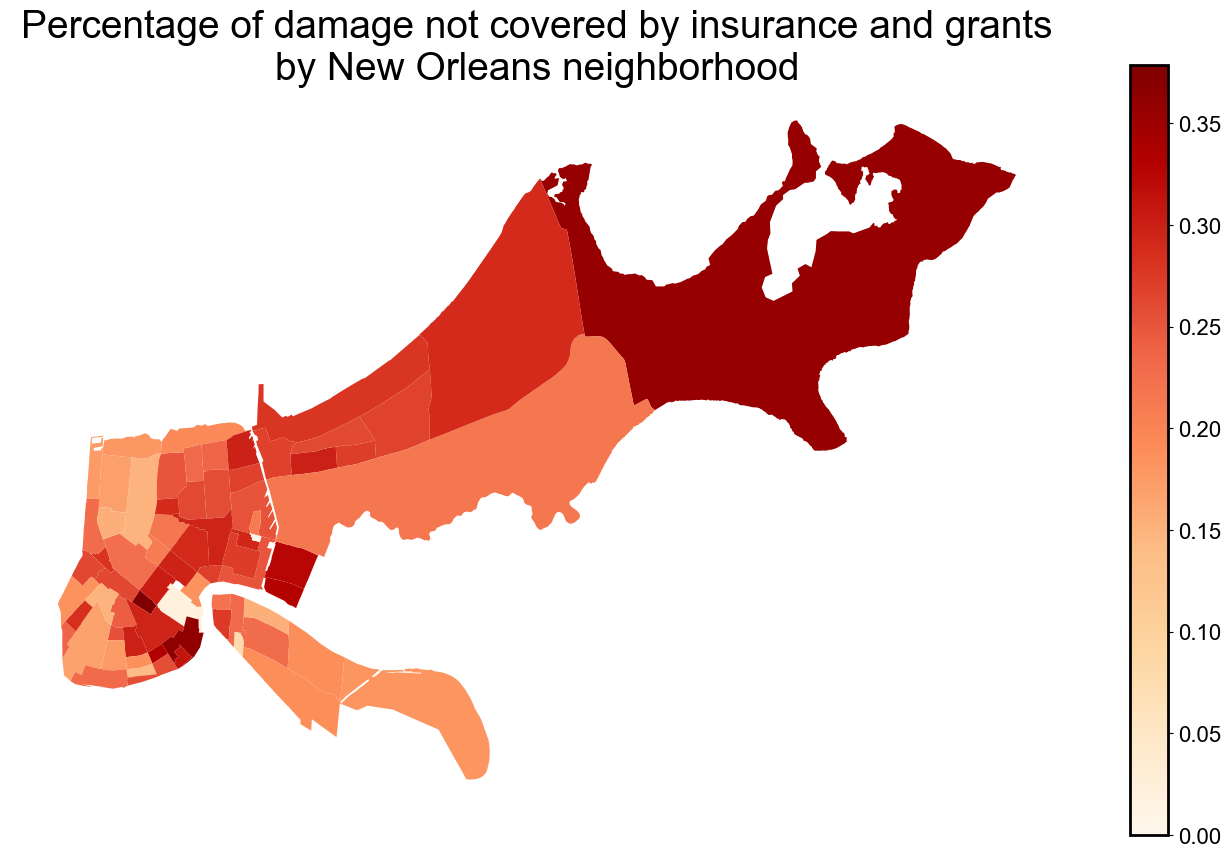

In [147]:
fig, ax = plt.subplots(figsize=(17,10))
rh_neighborhoods.plot(column='uncovered_percent', ax=ax, legend=True, cmap='OrRd')
plt.title('Percentage of damage not covered by insurance and grants\nby New Orleans neighborhood')
plt.grid(False)
plt.axis('off')
plt.show()
plt.close()

Function to generate the bucket and quintile tables

In [148]:
def table_maker(df, grouping, title, parishes=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Warnings supressed for clean output, otherwise double_scalar warning is triggered by divide by zero error calculating uncovered percent.
        if parishes:
            print(title)
            display(pd.concat([
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'all_grants_count' : 'sum'}).squeeze().rename('Count of Road Home properties'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'all_grants_count' : 'sum'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Road Home properties'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'total_pop' : 'sum'}).squeeze().rename('Population'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'total_pop' : 'sum'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Population'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'BKGPIDFP00' : 'count'}).squeeze().rename('Count of Block Groups'),
                df[(df['CNTYIDFP00'].isin(parishes))].groupby(grouping).agg({'BKGPIDFP00' : 'count'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Block Groups')

            ], axis=1))
        else:
            print(title)
            display(pd.concat([
                df.groupby(grouping).agg({'uncovered_sum' : 'sum', 'damage_sum' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1).rename('Uncovered Percent'),
                df.groupby(grouping).agg({'damage_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['damage_sum']/x['all_grants_count'], axis=1).rename('Mean damage'),
                df.groupby(grouping).agg({'grant_insurance_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['grant_insurance_sum']/x['all_grants_count'], axis=1).rename('Mean Grants and Insurance'),
                df.groupby(grouping).agg({'uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount'),
                df.groupby(grouping).agg({'cg_uncovered_sum' : 'sum', 'all_grants_count' : 'sum'}).apply(lambda x: x['cg_uncovered_sum']/x['all_grants_count'], axis=1).rename('Mean uncovered amount (before ACG)'),
                df.groupby(grouping).agg({'all_grants_count' : 'sum'}).squeeze().rename('Count of Road Home properties'),
                df.groupby(grouping).agg({'all_grants_count' : 'sum'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Road Home properties'),
                df.groupby(grouping).agg({'total_pop' : 'sum'}).squeeze().rename('Population'),
                df.groupby(grouping).agg({'total_pop' : 'sum'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Population'),
                df.groupby(grouping).agg({'BKGPIDFP00' : 'count'}).squeeze().rename('Count of Block Groups'),
                df.groupby(grouping).agg({'BKGPIDFP00' : 'count'}).apply(lambda x: x/x.sum()).squeeze().rename('Percent of Block Groups')
            ], axis=1))


One thing we haven't really discussed in depth is whether we want to use quintiles or buckets based equal intervals for the metrics we're looking at.

Normally I would think quintiles would be the best way to go, but given New Orleans skews more low income can create some issues. For example, the highest income quintile in the city goes from block groups with a median income of $42,000 to block groups with a median income of $146,000 and it feels like that's combining a lot of households with very different characteristics. But if we go with somewhat equal intervals we really don't have a lot of properties in the top income bucket. Only 499 properties are in the top bucket, even after that's extended to include all block groups with a median income of $80,000 or above. More than half the properties in our New Orleans analysis are between $20,000 and $40,000. Standard deviation for median income is $16,350.

This is less of an issue in the racial analysis.


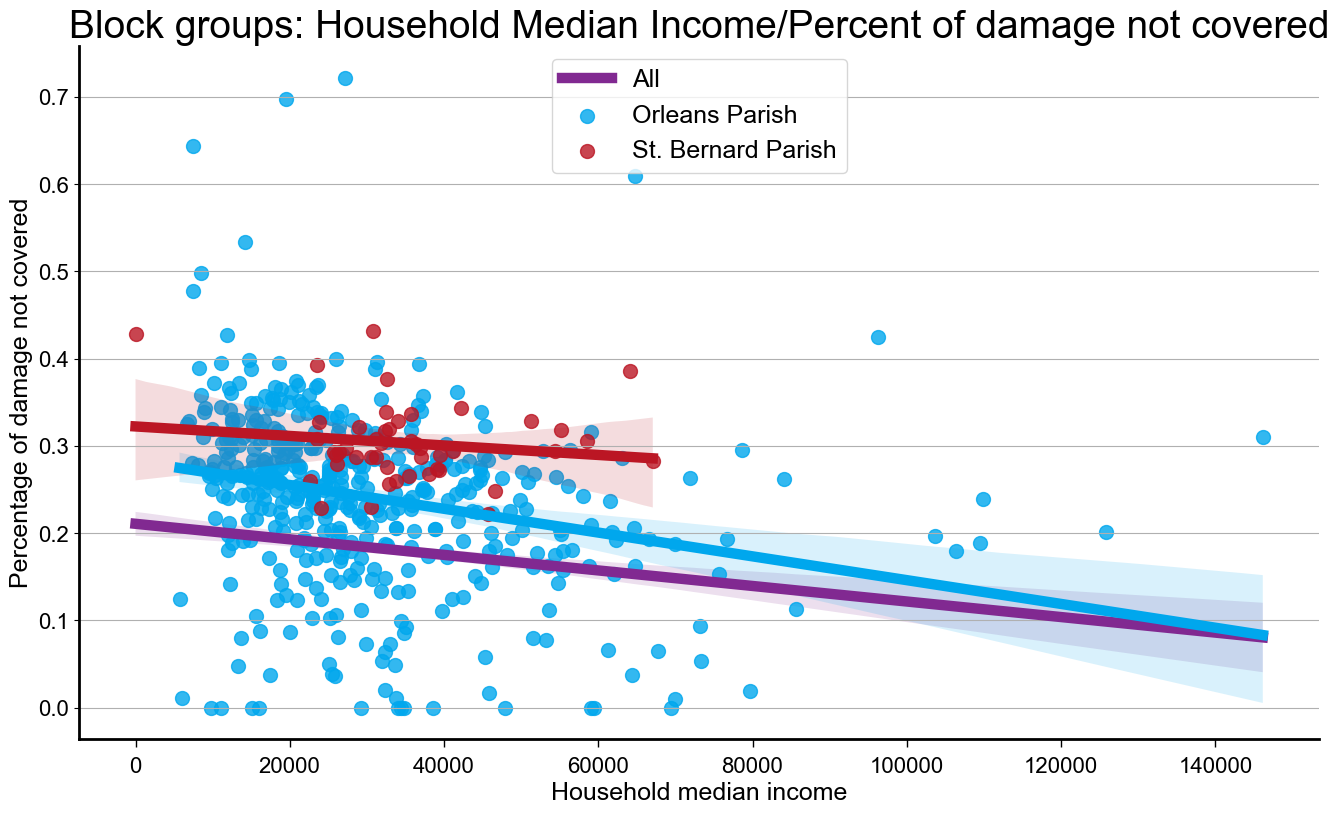

In [149]:
fig, ax = plt.subplots()

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0)], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C4'}, 
            scatter=False,
            label='All',
            ax=ax
            )


sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22071')], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22087')], 
            x='hh_median_income', 
            y='uncovered_percent', 
            line_kws={'color' : 'C1'}, 
            color='C1',
            label='St. Bernard Parish',
            ax=ax
            )
ax.set_xlabel('Household median income')
ax.set_ylabel('Percentage of damage not covered')

plt.title('Block groups: Household Median Income/Percent of damage not covered')
plt.legend(loc='upper center')
plt.show()
plt.close()

The same patterns we observed in earlier versions of the analyis hold true. Statewide and in Orleans, the lower the household median income, the more damage was left uncovered. The new analysis shows St. Bernard as being more flat across income groups, as opposed to earlier analysis which showed the uncovered percentage increasing as incomes rose.

In [150]:
table_maker(rh_bg_all, 'hh_median_income_quint', 'All RH properties by median income quintile')
table_maker(rh_bg_all, 'hh_median_income_bin', 'All RH properties by median income bucket')

All RH properties by median income quintile


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_quint,,,,,,,,,,,
"(-0.001, 21488.0]",0.28,"131,333.65","94,858.64","36,475.01","63,697.06","12,963.00",0.14,433322,0.15,175,0.34
"(21488.0, 28421.0]",0.26,"119,051.41","88,105.79","30,945.62","51,354.87","16,387.00",0.18,514685,0.18,108,0.21
"(28421.0, 34948.0]",0.26,"119,615.05","88,581.88","31,033.17","48,051.97","15,973.00",0.17,566297,0.20,72,0.14
"(34948.0, 44328.0]",0.25,"137,577.92","102,823.11","34,754.81","50,474.17","23,183.00",0.25,628451,0.22,68,0.13
"(44328.0, 146158.0]",0.20,"148,629.30","118,181.94","30,447.36","37,419.33","23,307.00",0.25,655048,0.23,90,0.18


All RH properties by median income bucket


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_bin,,,,,,,,,,,
"(0, 15000]",0.29,"133,531.12","95,206.37","38,324.76","65,370.84","3,151.00",0.03,130617,0.05,71,0.14
"(15000, 30000]",0.26,"122,537.93","90,212.04","32,325.89","54,683.55","29,989.00",0.33,954772,0.34,229,0.45
"(30000, 45000]",0.25,"132,701.23","98,992.06","33,709.17","49,785.38","37,160.00",0.40,1093290,0.39,128,0.25
"(45000, 60000]",0.21,"143,696.41","114,085.38","29,611.03","36,916.60","14,566.00",0.16,394170,0.14,51,0.10
"(60000, 75000]",0.20,"149,853.42","120,083.87","29,769.56","33,948.39","5,358.00",0.06,160376,0.06,20,0.04
"(75000, 200000]",0.19,"186,500.13","150,488.00","36,012.13","38,306.93","1,561.00",0.02,64565,0.02,13,0.03


In [151]:
rh_bg_all[(rh_bg_all['hh_median_income']>80000) & (rh_bg_all['CNTYIDFP00']=='22071')][['damage_sum', 'uncovered_sum']].sum()

damage_sum      97,989,194.30
uncovered_sum   20,839,653.09
dtype: float64

In New Orleans, properties in block groups where the median income was less than $20,000 a year had 27% of their damage left uncovered. Those living in block groups with a median income above $80,000 had 17% of their damage uncovered. 

In [152]:
table_maker(rh_bg_all, 'hh_median_income_quint_orleans', 'Orleans RH properties by median income quintile', parishes=['22071'])
table_maker(rh_bg_all, 'hh_median_income_bin', 'Orleans RH properties by median income bucket', parishes=['22071'])

Orleans RH properties by median income quintile


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_quint_orleans,,,,,,,,,,,,
"(5702.999, 16580.0]",0.29,"181,820.88","129,154.36","52,666.51","89,311.82","89,311.82","3,416.00",0.11,86624,0.19,94,0.20
"(16580.0, 22692.0]",0.28,"174,831.16","125,558.25","49,272.91","82,334.49","82,334.49","4,456.00",0.15,85690,0.18,94,0.20
"(22692.0, 29250.0]",0.26,"182,895.53","135,256.22","47,639.31","76,489.66","76,489.66","5,794.00",0.19,88229,0.19,92,0.20
"(29250.0, 41806.0]",0.26,"205,325.72","152,530.25","52,795.47","79,161.34","79,161.34","9,415.00",0.31,116120,0.25,93,0.20
"(41806.0, 146158.0]",0.23,"231,451.30","178,492.61","52,958.69","65,502.26","65,502.26","7,126.00",0.24,90738,0.19,93,0.20


Orleans RH properties by median income bucket


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_bin,,,,,,,,,,,,
"(0, 15000]",0.30,"183,175.64","128,705.15","54,470.49","89,958.02","89,958.02","1,956.00",0.06,59462,0.13,71,0.15
"(15000, 30000]",0.27,"178,711.08","130,324.33","48,386.75","79,666.26","79,666.26","12,407.00",0.41,213337,0.46,217,0.47
"(30000, 45000]",0.25,"207,395.87","154,684.39","52,711.48","78,311.62","78,311.62","10,348.00",0.34,119195,0.26,102,0.22
"(45000, 60000]",0.23,"231,875.13","178,661.44","53,213.69","65,436.81","65,436.81","3,626.00",0.12,44484,0.10,45,0.10
"(60000, 75000]",0.23,"261,935.60","202,494.78","59,440.82","66,646.28","66,646.28","1,256.00",0.04,17303,0.04,18,0.04
"(75000, 200000]",0.20,"245,676.54","196,822.41","48,854.13","51,300.54","51,300.54",614.00,0.02,13620,0.03,13,0.03


In [153]:
table_maker(rh_bg_all, 'hh_median_income_quint_st_bernard', 'St. Bernard RH properties by median income quintile', parishes=['22087'])
table_maker(rh_bg_all, 'hh_median_income_bin', 'St. Bernard RH properties by median income bucket', parishes=['22087'])

St. Bernard RH properties by median income quintile


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_quint_st_bernard,,,,,,,,,,,,
"(-0.001, 26545.8]",0.31,"183,141.14","127,080.87","56,060.27","87,844.76","87,844.76","1,123.00",0.19,12162,0.18,10,0.21
"(26545.8, 32062.6]",0.30,"192,630.00","135,434.19","57,195.81","82,239.20","82,239.20","1,347.00",0.23,13281,0.20,9,0.19
"(32062.6, 35596.2]",0.31,"216,629.38","150,071.59","66,557.79","94,606.59","94,606.59",940.00,0.16,11314,0.17,9,0.19
"(35596.2, 40848.6]",0.29,"214,144.70","151,681.87","62,462.84","94,320.19","94,320.19","1,361.00",0.23,13784,0.21,9,0.19
"(40848.6, 67067.0]",0.30,"263,246.19","183,341.90","79,904.29","99,420.75","99,420.75","1,141.00",0.19,16688,0.25,10,0.21


St. Bernard RH properties by median income bucket


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
hh_median_income_bin,,,,,,,,,,,,
"(0, 15000]",NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0,0.00,0,0.00
"(15000, 30000]",0.30,"179,109.65","124,747.61","54,362.04","85,090.21","85,090.21","1,753.00",0.30,16658,0.25,12,0.26
"(30000, 45000]",0.30,"216,109.76","151,698.87","64,410.89","92,456.05","92,456.05","3,151.00",0.53,35841,0.53,26,0.57
"(45000, 60000]",0.30,"251,659.09","176,922.41","74,736.69","94,277.17","94,277.17",706.00,0.12,10617,0.16,6,0.13
"(60000, 75000]",0.31,"292,917.67","200,975.04","91,942.63","109,724.45","109,724.45",297.00,0.05,4113,0.06,2,0.04
"(75000, 200000]",NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0,0.00,0,0.00


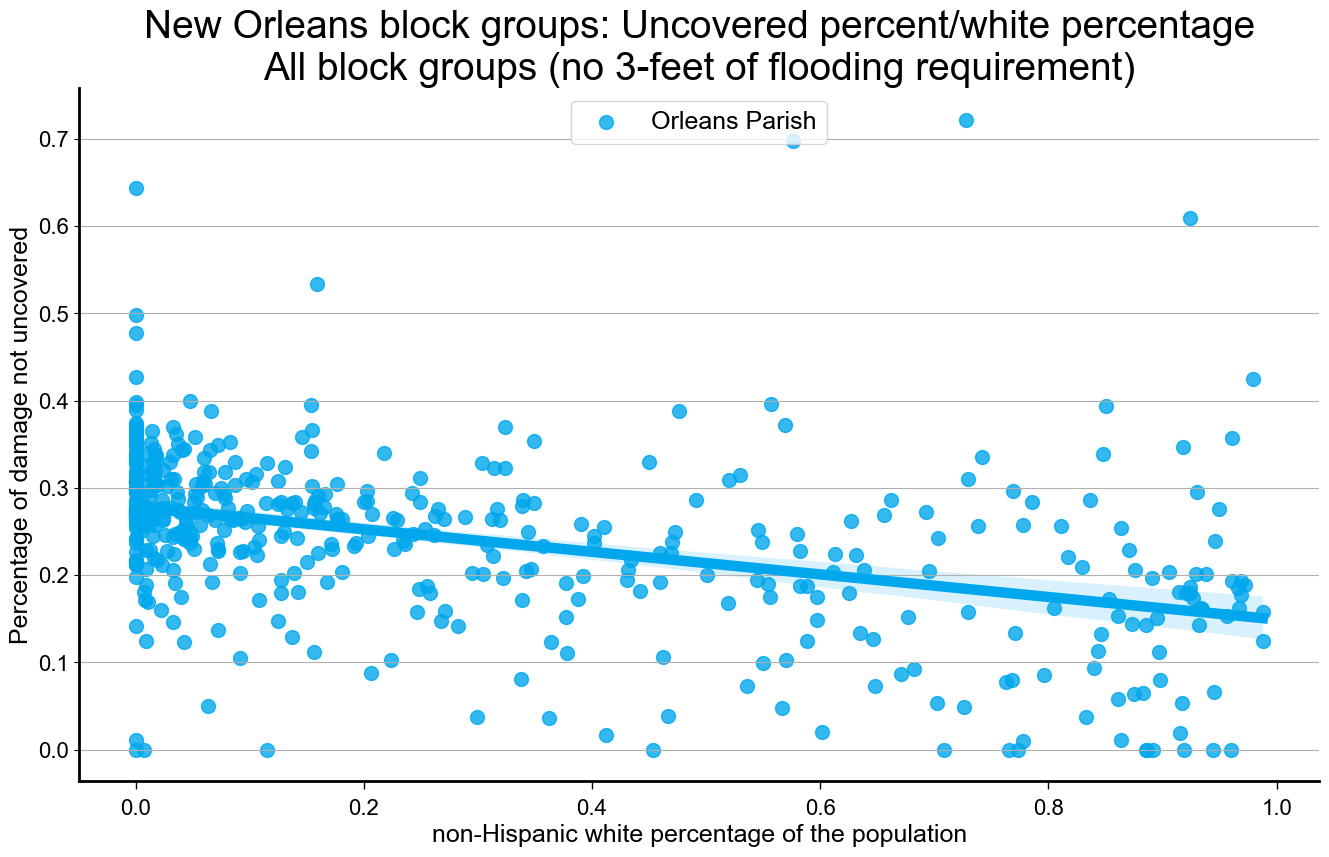

In [154]:
fig, ax = plt.subplots()

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22071')], 
            x='white_percent', 
            y='uncovered_percent', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )
ax.set_xlabel('non-Hispanic white percentage of the population')
ax.set_ylabel('Percentage of damage not uncovered')
plt.title('New Orleans block groups: Uncovered percent/white percentage\nAll block groups (no 3-feet of flooding requirement)')
plt.legend(loc='upper center')
plt.show()
plt.close()

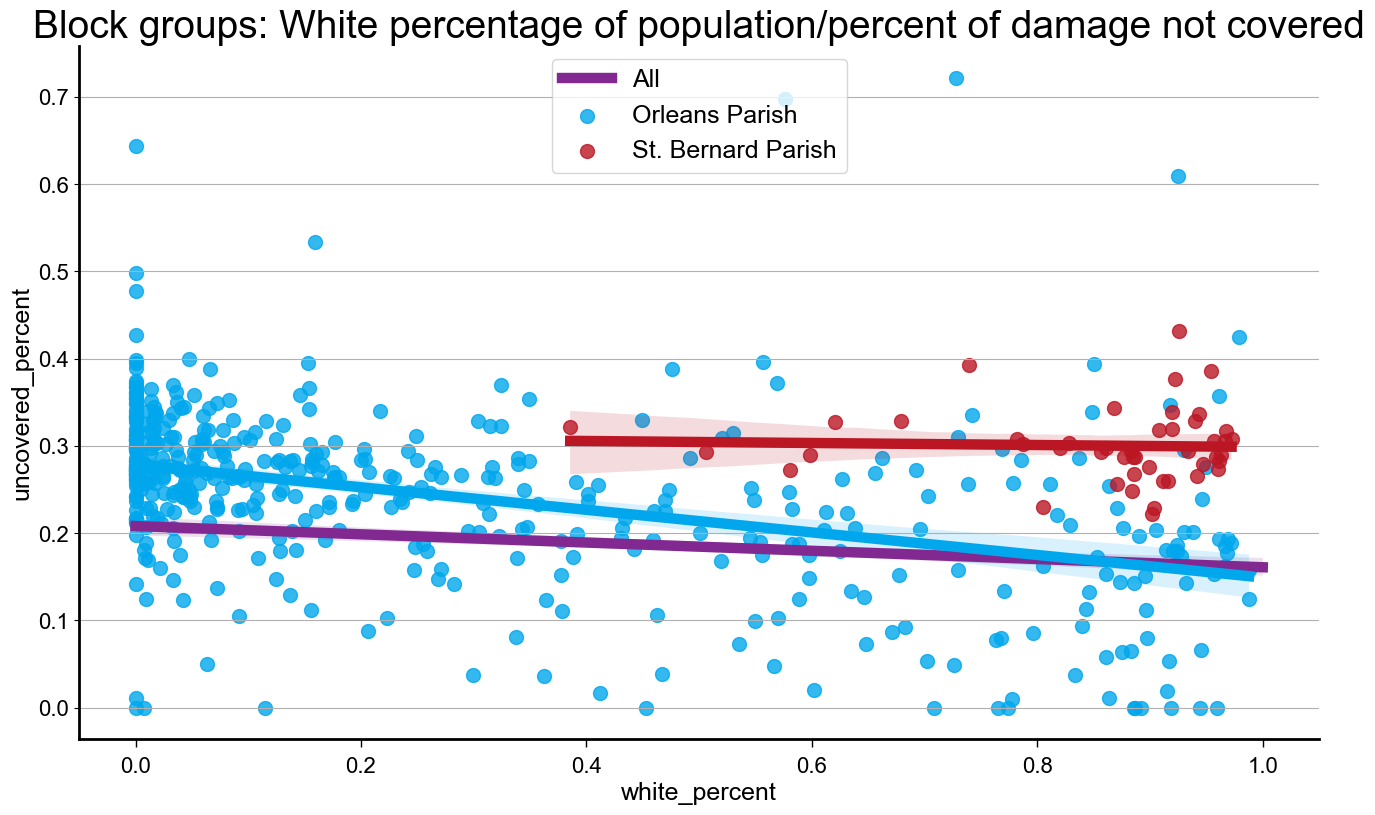

In [155]:
fig, ax = plt.subplots()

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0)], 
            x='white_percent', 
            y='uncovered_percent', 
            line_kws={'color' : 'C4'}, 
            scatter=False,
            label='All',
            ax=ax
            )


sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22071')], 
            x='white_percent', 
            y='uncovered_percent', 
            line_kws={'color' : 'C0'}, 
            color='C0',
            label='Orleans Parish',
            ax=ax
            )

sns.regplot(rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22087')], 
            x='white_percent', 
            y='uncovered_percent', 
            line_kws={'color' : 'C1'}, 
            color='C1',
            label='St. Bernard Parish',
            ax=ax
            )



plt.legend(loc='upper center')


# rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22071')].plot(kind='scatter', x='white_percent', y='uncovered_percent', ax=ax, color='C0')
# rh_bg_all[(rh_bg_all['damage_sum']>0) & (rh_bg_all['CNTYIDFP00']=='22087')].plot(kind='scatter', x='white_percent', y='uncovered_percent', ax=ax, color='C1')
plt.title('Block groups: White percentage of population/percent of damage not covered')
plt.show()
plt.close()

In [156]:
table_maker(rh_bg_all, 'white_percent_quint', 'All RH properties by white percent quintile')
table_maker(rh_bg_all, 'white_percent_bins', 'All RH properties by white percent bucket')

All RH properties by white percent quintile


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
white_percent_quint,,,,,,,,,,,
"(-0.001, 0.171]",0.27,"166,582.38","121,220.03","45,362.34","73,625.90","25,758.00",0.28,468233,0.17,254,0.50
"(0.171, 0.557]",0.24,"110,173.71","84,087.76","26,085.95","41,381.32","17,380.00",0.19,543626,0.19,104,0.20
"(0.557, 0.796]",0.22,"104,081.19","81,448.77","22,632.42","33,322.41","15,877.00",0.17,580373,0.21,53,0.10
"(0.796, 0.918]",0.22,"122,461.37","95,750.01","26,711.36","36,699.80","17,181.00",0.19,610484,0.22,54,0.11
"(0.918, 1.0]",0.24,"144,423.07","109,161.10","35,261.97","44,916.89","15,600.00",0.17,595087,0.21,47,0.09


All RH properties by white percent bucket


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
white_percent_bins,,,,,,,,,,,
Less than 20%,0.27,"168,077.41","122,799.49","45,277.92","71,821.22","22,515.00",0.26,616425,0.14,192,0.43
20% to 40%,0.24,"119,218.26","91,014.53","28,203.74","43,374.52","9,123.00",0.11,405763,0.09,62,0.14
40% to 60%,0.23,"96,395.20","74,502.73","21,892.47","35,341.19","8,931.00",0.10,528085,0.12,47,0.11
60% to 80%,0.22,"101,785.75","79,035.65","22,750.11","33,169.09","13,966.00",0.16,886474,0.21,42,0.09
More than 80%,0.23,"133,294.61","102,678.62","30,615.99","40,352.04","32,271.00",0.37,1885294,0.44,104,0.23


As with the income analysis, the past racial analyses hold true in New Orleans. The whiter a block group the less damage was uncovered there.

In [157]:
table_maker(rh_bg_all, 'white_percent_quint_orleans', 'Orleans RH properties by white percent quintile', parishes=['22071'])
table_maker(rh_bg_all, 'white_percent_bins', 'Orleans RH properties by white percent bucket', parishes=['22071'])

Orleans RH properties by white percent quintile


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
white_percent_quint_orleans,,,,,,,,,,,,
"(-0.001, 0.011]",0.29,"192,404.83","136,868.47","55,536.36","98,604.65","98,604.65","4,327.00",0.14,77378,0.17,94,0.20
"(0.011, 0.0719]",0.28,"200,660.13","145,225.19","55,434.94","88,169.97","88,169.97","8,340.00",0.28,114903,0.25,93,0.20
"(0.0719, 0.247]",0.27,"196,098.04","142,944.73","53,153.30","79,397.62","79,397.62","8,300.00",0.27,102968,0.22,93,0.20
"(0.247, 0.631]",0.23,"175,777.82","134,991.60","40,786.22","56,293.55","56,293.55","5,100.00",0.17,92154,0.20,93,0.20
"(0.631, 0.988]",0.20,"244,489.46","196,632.29","47,857.17","52,929.64","52,929.64","4,140.00",0.14,79998,0.17,93,0.20


Orleans RH properties by white percent bucket


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
white_percent_bins,,,,,,,,,,,,
Less than 20%,0.27,"198,406.48","144,045.22","54,361.26","84,800.29","84,800.29","16,881.00",0.63,228050,0.54,192,0.48
20% to 40%,0.24,"188,505.07","142,569.62","45,935.45","66,076.30","66,076.30","3,898.00",0.14,57607,0.14,61,0.15
40% to 60%,0.22,"149,836.34","116,966.44","32,869.91","42,268.33","42,268.33","1,663.00",0.06,42930,0.10,44,0.11
60% to 80%,0.22,"170,896.54","132,925.13","37,971.41","43,697.27","43,697.27","1,103.00",0.04,35139,0.08,37,0.09
More than 80%,0.19,"262,449.40","212,213.40","50,235.99","55,146.79","55,146.79","3,338.00",0.12,55571,0.13,67,0.17


In [158]:
(
    rh_neighborhoods[rh_neighborhoods['damage_sum']>0][
        [   'NBHD',
            'damage_sum', 
            'grant_insurance_sum', 
            'grant_insurance_mean', 
            'uncovered_sum', 
            'uncovered_mean', 
            'uncovered_percent', 
            'white_percent',
    ]
]
.sort_values(by='uncovered_percent')
.rename(columns = 
    {
        'damage_sum' : 'Sum of damage',
        'grant_insurance_sum' : 'Sum of grants+insurance',
        'grant_insurance_mean' : 'Mean grants+insurance per property that received grants',
        'uncovered_sum' : 'Total amount left uncovered by grants+insurance',
        'uncovered_mean' : 'Mean amount left uncovered per property that received grants',
        'uncovered_percent' : 'Percent of damage left uncovered',
        'white_percent' : 'Non-Hispanic White population percentage',
    }
)
)

,NBHD,Sum of damage,Sum of grants+insurance,Mean grants+insurance per property that received grants,Total amount left uncovered by grants+insurance,Mean amount left uncovered per property that received grants,Percent of damage left uncovered,Non-Hispanic White population percentage
22,Florida Development,"255,044.00","255,044.00","127,522.00",0.00,0.00,0.00,0.00
9,Central Business District,"600,443.95","589,644.73","98,274.12","10,799.22","1,799.87",0.02,0.61
20,Fischer Project,"1,026,105.84","945,879.34","72,759.95","80,226.50","6,171.27",0.08,0.00
17,East Riverside,"5,169,273.29","4,439,214.20","59,189.52","730,059.09","9,734.12",0.14,0.31
43,Marlyville/Fountainebleau,"54,826,611.50","46,568,583.88","144,175.18","8,258,027.62","25,566.65",0.15,0.61
11,City Park,"16,824,317.06","14,289,150.50","118,092.15","2,535,166.56","20,951.79",0.15,0.82
48,Navarre,"82,385,560.71","69,693,086.25","192,522.34","12,692,474.46","35,062.08",0.15,0.89
66,U.S. Naval Base Neighborhood,"5,518,963.69","4,664,363.41","42,792.32","854,600.28","7,840.37",0.15,0.30
2,Audubon,"31,880,214.14","26,518,366.40","138,116.49","5,361,847.74","27,926.29",0.17,0.86
36,Lakeview Neighborhood,"392,840,029.31","326,526,528.64","237,473.84","66,313,500.67","48,228.00",0.17,0.93


In [159]:
table_maker(rh_bg_all, 'white_percent_quint_st_bernard', 'St. Bernard RH properties by white percent quintile', parishes=['22087'])
table_maker(rh_bg_all, 'white_percent_bins', 'St. Bernard RH properties by white percent bucket', parishes=['22087'])

St. Bernard RH properties by white percent quintile


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
white_percent_quint_st_bernard,,,,,,,,,,,,
"(0.385, 0.805]",0.31,"193,034.88","133,815.75","59,219.13","93,995.31","93,995.31","1,650.00",0.28,17538,0.26,10,0.22
"(0.805, 0.884]",0.29,"190,859.34","135,560.94","55,298.41","80,347.07","80,347.07","1,165.00",0.20,10325,0.15,9,0.20
"(0.884, 0.916]",0.28,"217,622.72","157,499.89","60,122.83","86,000.25","86,000.25","1,023.00",0.17,12524,0.19,9,0.20
"(0.916, 0.947]",0.33,"239,280.75","161,171.40","78,109.35","103,433.53","103,433.53",830.00,0.14,12327,0.18,9,0.20
"(0.947, 0.972]",0.30,"240,128.49","167,605.63","72,522.86","94,524.05","94,524.05","1,239.00",0.21,14515,0.22,9,0.20


St. Bernard RH properties by white percent bucket


,Uncovered Percent,Mean damage,Mean Grants and Insurance,Mean uncovered amount,Mean uncovered amount (before ACG),Mean uncovered amount (before ACG),Count of Road Home properties,Percent of Road Home properties,Population,Percent of Population,Count of Block Groups,Percent of Block Groups
white_percent_bins,,,,,,,,,,,,
Less than 20%,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0,0.00,0,0.00
20% to 40%,0.32,"197,451.19","133,951.00","63,500.20","93,268.55","93,268.55",132.00,0.02,1180,0.02,1,0.02
40% to 60%,0.28,"198,911.73","142,716.22","56,195.50","95,012.36","95,012.36",598.00,0.10,5835,0.09,3,0.07
60% to 80%,0.33,"194,421.90","130,145.99","64,275.92","98,603.93","98,603.93",809.00,0.14,9307,0.14,5,0.11
More than 80%,0.30,"219,164.11","154,067.90","65,096.22","89,455.26","89,455.26","4,368.00",0.74,50907,0.76,37,0.80


An analysis of race and income is a bit messier. Note the 43% uncovered in the 40%-60% white and less than $20,000 category is due to the CBD property I mentioned earlier.

In [160]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Average uncovered percentage based on race and income')
    display(
        rh_bg_all[
            (rh_bg_all['compensation_sum']>0) &
            (rh_bg_all['CNTYIDFP00']=='22071')
            ]
            .groupby(['white_percent_bins', 'hh_median_income_bin'])
            .agg({
                'uncovered_sum' : 'sum',
                'damage_sum' : 'sum'
                })
            .apply(lambda x: x['uncovered_sum']/x['damage_sum'], axis=1)
            .unstack()
            .fillna('-')
    )

Average uncovered percentage based on race and income


hh_median_income_bin,"(0, 15000]","(15000, 30000]","(30000, 45000]","(45000, 60000]","(60000, 75000]","(75000, 200000]"
white_percent_bins,,,,,,
Less than 20%,0.29,0.28,0.27,0.29,0.26,-
20% to 40%,0.29,0.22,0.24,0.28,-,-
40% to 60%,0.27,0.21,0.24,0.20,0.22,-
60% to 80%,0.08,0.26,0.14,0.22,0.28,0.26
More than 80%,-,0.14,0.22,0.17,0.17,0.19


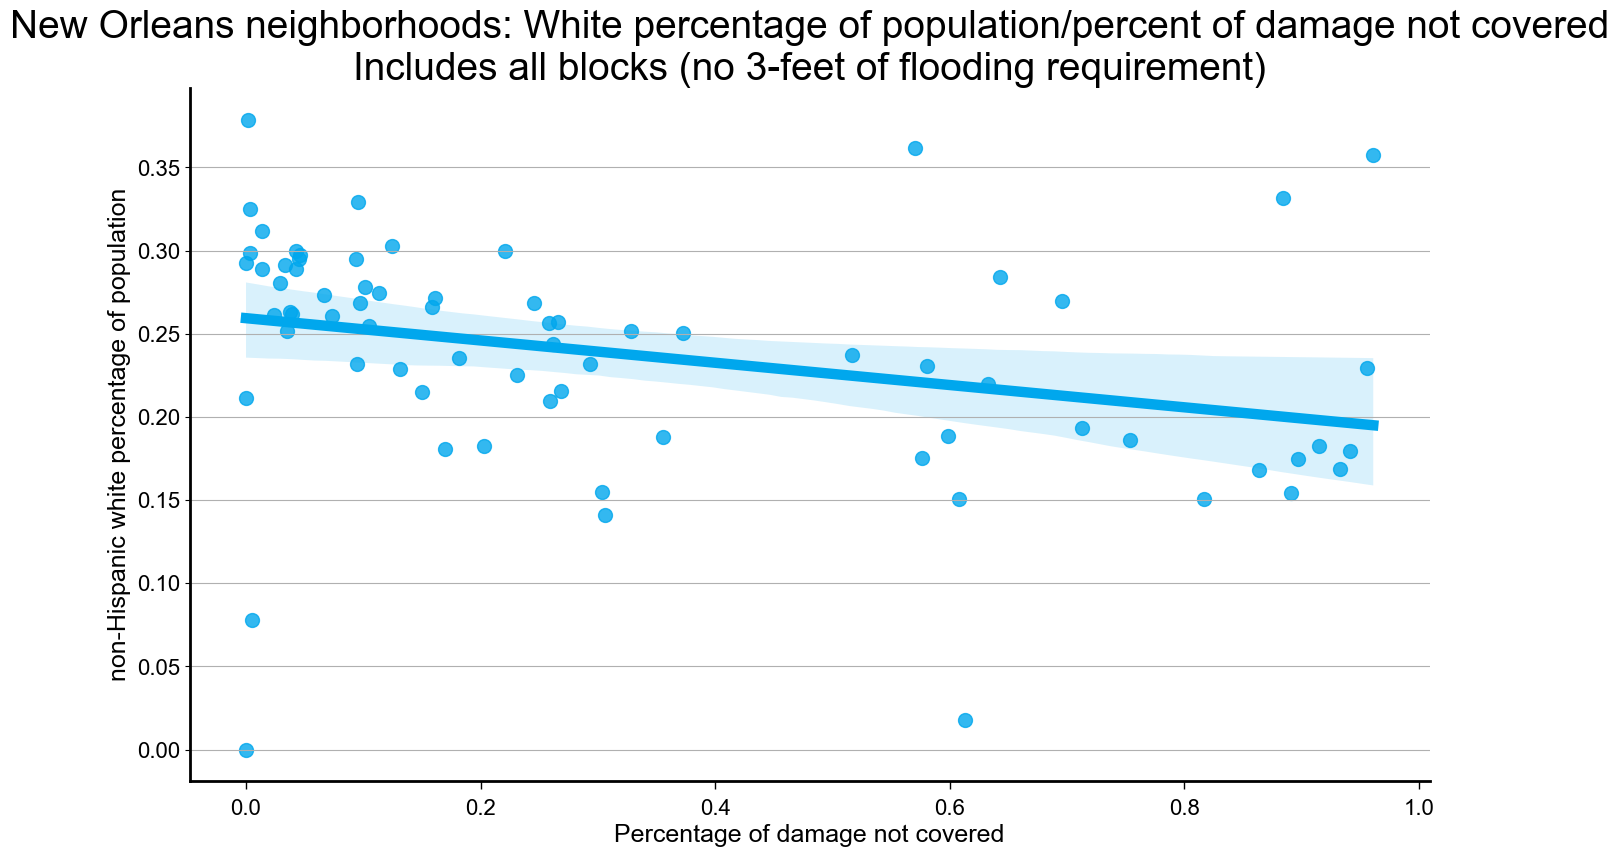

In [161]:
fig, ax = plt.subplots()
sns.regplot(rh_neighborhoods[(rh_neighborhoods['damage_sum']>0)], x='white_percent', y='uncovered_percent', line_kws={'color' : 'C0'}, ax=ax)
plt.title('New Orleans neighborhoods: White percentage of population/percent of damage not covered\nIncludes all blocks (no 3-feet of flooding requirement)')
ax.set_xlabel('Percentage of damage not covered')
ax.set_ylabel('non-Hispanic white percentage of population')
plt.show()
plt.close()

In [162]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Details of payments for all properties by income quintile')
    display(
        rh_bg_all
            .groupby('hh_median_income_quint')
            .agg({
                'compensation_sum' : 'sum', 
                'additional_compensation_sum' : 'sum' ,
                'insurance_sum' : 'sum'
                })
            .rename(columns = {
                'compensation_sum' : 'Total payment from Compenation Grants',
                'additional_compensation_sum' : 'Total payment from Additional Compensation Grants',
                'insurance_sum' : 'Total payment from insurance'
                
            }
                )
    )

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print('Details of percent of payments for all properties by income quintile')
    display(
        rh_bg_all
            .groupby('hh_median_income_quint')
            .agg({
                'compensation_sum' : 'sum', 
                'additional_compensation_sum' : 'sum' ,
                'insurance_sum' : 'sum'
                })
            .apply(lambda x: x/x.sum(), axis=1)
            .rename(columns = {
                'compensation_sum' : 'Percent of payment from Compenation Grants',
                'additional_compensation_sum' : 'Percent of payment from Additional Compensation Grants',
                'insurance_sum' : 'Percent of payment from insurance'
                
            }
                )
    )

Details of payments for all properties by income quintile


,Total payment from Compenation Grants,Total payment from Additional Compensation Grants,Total payment from insurance
hh_median_income_quint,,,
"(-0.001, 21488.0]","537,825,750.68","352,879,444.87","338,947,372.29"
"(21488.0, 28421.0]","642,850,520.20","334,446,371.86","466,492,643.89"
"(28421.0, 34948.0]","616,928,855.98","271,841,212.97","526,148,324.95"
"(34948.0, 44328.0]","977,505,850.69","364,421,993.98","1,041,820,280.35"
"(44328.0, 146158.0]","1,157,165,178.96","162,495,792.42","1,434,805,546.90"


Details of percent of payments for all properties by income quintile


,Percent of payment from Compenation Grants,Percent of payment from Additional Compensation Grants,Percent of payment from insurance
hh_median_income_quint,,,
"(-0.001, 21488.0]",0.44,0.29,0.28
"(21488.0, 28421.0]",0.45,0.23,0.32
"(28421.0, 34948.0]",0.44,0.19,0.37
"(34948.0, 44328.0]",0.41,0.15,0.44
"(44328.0, 146158.0]",0.42,0.06,0.52


In [163]:
print('Effects of Additional Compensation Grants')
rh_bg_all['cg_plus_insurance'] = rh_bg_all['compensation_sum']+rh_bg_all['insurance_sum']
bg_acg_compare = rh_bg_all[(rh_bg_all['compensation_sum']>0) & (rh_bg_all['CNTYIDFP00'].isin(['22071', '22087']))].groupby('hh_median_income_bin').agg({'cg_plus_insurance' : 'sum' , 'grant_insurance_sum' : 'sum', 'damage_sum' : 'sum'})
bg_acg_compare['uncovered_percent_cg_insurance'] = 1-(bg_acg_compare['cg_plus_insurance']/bg_acg_compare['damage_sum'])
bg_acg_compare['uncovered_percent'] = 1-(bg_acg_compare['grant_insurance_sum']/bg_acg_compare['damage_sum'])
bg_acg_compare['difference'] = bg_acg_compare['uncovered_percent_cg_insurance']-bg_acg_compare['uncovered_percent']
bg_acg_compare.rename(columns={
    'cg_plu_insurance' : 'Compensation+Insurance only',
    'grant_insurance_sum' : 'Compensation+Additional Compensation+Insurance',
    'damage_sum' : 'Total damage',
    'uncovered_percent_cg_insurance' : 'Percent uncovered with Compensation+Insurance only',
    'uncovered_percent' : 'Percent uncovered with Compensation+Additional Compensation+Insurance',
    'difference' : 'Percentage point difference between C+I and C+AC+I'
})

Effects of Additional Compensation Grants


,cg_plus_insurance,Compensation+Additional Compensation+Insurance,Total damage,Percent uncovered with Compensation+Insurance only,Percent uncovered with Compensation+Additional Compensation+Insurance,Percentage point difference between C+I and C+AC+I
hh_median_income_bin,,,,,,
"(0, 15000]","182,333,658.59","251,747,266.68","358,291,547.18",0.49,0.30,0.19
"(15000, 30000]","1,393,665,213.60","1,835,616,473.76","2,531,247,575.78",0.45,0.27,0.17
"(30000, 45000]","1,725,396,652.14","2,078,677,211.82","2,827,094,315.25",0.39,0.26,0.12
"(45000, 60000]","714,616,963.48","772,733,588.21","1,018,450,531.27",0.30,0.24,0.06
"(60000, 75000]","299,691,782.05","314,023,034.15","415,987,667.13",0.28,0.25,0.03
"(75000, 200000]","119,346,860.51","120,848,960.74","150,845,395.11",0.21,0.20,0.01


In [164]:
wo_acg = rh_neighborhoods[rh_neighborhoods['damage_sum']>0].set_index('NBHD')[['compensation_sum', 'insurance_sum', 'damage_sum', 'all_grants_count']].apply(lambda x: (x['damage_sum'] - (x['compensation_sum']+x['insurance_sum']))/x['damage_sum'], axis=1).sort_values(ascending=False)
w_acg = rh_neighborhoods[rh_neighborhoods['damage_sum']>0].set_index('NBHD')['uncovered_percent']

acg_compare = pd.concat([wo_acg.rename('Without ACG'), w_acg.rename('With ACG')], axis=1)
acg_compare['Difference'] = acg_compare['Without ACG'] - acg_compare['With ACG']
acg_compare.sort_values(by="Difference")

,Without ACG,With ACG,Difference
NBHD,,,
Central Business District,0.02,0.02,0.00
Garden District,0.33,0.33,0.00
Lakewood,0.23,0.23,0.00
Lake Terrace & Oaks,0.20,0.19,0.01
City Park,0.16,0.15,0.01
Lakeshore/Lake Vista,0.19,0.18,0.01
Lakeview Neighborhood,0.18,0.17,0.01
Audubon,0.18,0.17,0.02
West End,0.19,0.17,0.02


In [165]:
print('By white percentage of population')
display(
    pd.concat([
        rh_bg_all[(rh_bg_all['compensation_sum']>0)]
        .groupby('white_percent_bins')
        .agg({
            'compensation_sum' : 'sum', 
            'insurance_sum' : 'sum', 
            'damage_sum' : 'sum'})
        .apply(lambda x: (x['damage_sum']-(x['compensation_sum']+x['insurance_sum']))/x['damage_sum'], axis=1)
        .rename('CG and Insurance only'),
        rh_bg_all[rh_bg_all['compensation_sum']>0]
        .groupby('white_percent_bins')
        .agg({
            'compensation_sum' : 'sum', 
            'insurance_sum' : 'sum', 
            'additional_compensation_sum' : 'sum',
            'damage_sum' : 'sum'})
        .apply(lambda x: (x['damage_sum']-(x['compensation_sum']+x['insurance_sum']+x['additional_compensation_sum']))/x['damage_sum'], axis=1)
        .rename('CG, ACG and Insurance')
    ], axis=1)
)


print('By median income')
display(
    pd.concat([
        rh_bg_all[(rh_bg_all['compensation_sum']>0)]
        .groupby('hh_median_income_bin')
        .agg({
            'compensation_sum' : 'sum', 
            'insurance_sum' : 'sum', 
            'damage_sum' : 'sum'})
        .apply(lambda x: (x['damage_sum']-(x['compensation_sum']+x['insurance_sum']))/x['damage_sum'], axis=1)
        .rename('CG and Insurance only'),
        rh_bg_all[rh_bg_all['compensation_sum']>0]
        .groupby('hh_median_income_bin')
        .agg({
            'compensation_sum' : 'sum', 
            'insurance_sum' : 'sum', 
            'additional_compensation_sum' : 'sum',
            'damage_sum' : 'sum'})
        .apply(lambda x: (x['damage_sum']-(x['compensation_sum']+x['insurance_sum']+x['additional_compensation_sum']))/x['damage_sum'], axis=1)
        .rename('CG, ACG and Insurance')
    ], axis=1)
)

By white percentage of population


,CG and Insurance only,"CG, ACG and Insurance"
white_percent_bins,,
Less than 20%,0.43,0.27
20% to 40%,0.36,0.24
40% to 60%,0.37,0.23
60% to 80%,0.33,0.22
More than 80%,0.30,0.23


By median income


,CG and Insurance only,"CG, ACG and Insurance"
hh_median_income_bin,,
"(0, 15000]",0.49,0.29
"(15000, 30000]",0.45,0.26
"(30000, 45000]",0.38,0.25
"(45000, 60000]",0.26,0.21
"(60000, 75000]",0.23,0.20
"(75000, 200000]",0.21,0.19


The below cell is in case we decide to do bins/quints by individual property instead of block groups. This will add all the needed fields to the individual level records, based on their block group.

In [166]:
rh_clean_helper = rh_clean.rename(columns = {
                    'Census Block' : 'GEOID',
                    'Total CG Amount' : 'compensation_sum',
                    'Total ACG Amunt' : 'additional_compensation_sum',
                    'Total Elevation Amount' : 'elevation_sum',
                    'Total IMM Amount' : 'mitigation_sum',
                    'TOTAL_CLOSING_AMOUNT' : 'all_grants_sum',
                    'Closing Option' : 'all_grants_count',
                    'Current PSV' : 'pre_storm_value_sum',
                    'Current Damage Assessment' : 'damage_sum',
                    'DOB (no legal fees)' : 'insurance_sum',
                    'Current Damage Assessment - Type 1 (Replace)' : 'damage_type_1',
                    'Current Damage Assessment - Type 2 (Repair)' : 'damage_type_2'

})
rh_clean_helper['Census Block'] = rh_clean_helper['GEOID'].astype(str).str[:15]
rh_clean_helper['BKGPIDFP00'] = rh_clean_helper['Census Block'].str[:12]
rh_clean_helper['CNTYIDFP00'] = rh_clean_helper['Census Block'].astype(str).str[:5]
rh_clean_helper = rh_clean_helper.merge(income, left_on='BKGPIDFP00', right_on='GEOID')
rh_clean_helper = helper_fields(rh_clean_helper)

rh_clean_helper['hh_median_income_bin'] = pd.cut(
    rh_clean_helper['hh_median_income'], 
    bins=[0,20000,40000,60000,80000,200000], 
    labels=['Less than $20,000', '$20,000 - $40,000', '$40,000 - $60,000', '$60,000 - $80,000', 'More than $80,000'])
rh_clean_helper['hh_median_income_quint'] = pd.qcut(rh_clean_helper[(rh_clean_helper['CNTYIDFP00'].isin(['22071', '22087'])) & (rh_clean_helper['compensation_sum']>0)]['hh_median_income'], q=5)
rh_clean_helper['hh_median_income_quint_orleans'] = pd.qcut(rh_clean_helper[(rh_clean_helper['CNTYIDFP00'].isin(['22071']) & (rh_clean_helper['compensation_sum']>0))]['hh_median_income'], q=5)
rh_clean_helper['hh_median_income_quint_st_bernard'] = pd.qcut(rh_clean_helper[(rh_clean_helper['CNTYIDFP00'].isin(['22087'])) & (rh_clean_helper['compensation_sum']>0)]['hh_median_income'], q=5)
rh_clean_helper['percent_poverty_bins'] = pd.cut(rh_clean_helper['percent_poverty_status'], bins=[0,.2,.4,.6,.8,1], labels = ['Less than 20%', '20% to 40%', '40% to 60%', '60% to 80%', 'More than 80%'])
rh_clean_helper['percent_poverty_quint'] = pd.qcut(rh_clean_helper[rh_clean_helper['compensation_sum']>0]['percent_poverty_status'], q=5)
rh_clean_helper['percent_poverty_quint_orleans'] = pd.qcut(rh_clean_helper[(rh_clean_helper['compensation_sum']>0) & (rh_clean_helper['CNTYIDFP00'].isin(['22071']))]['percent_poverty_status'], q=5)
rh_clean_helper['percent_poverty_quint_st_bernard'] = pd.qcut(rh_clean_helper[(rh_clean_helper['compensation_sum']>0) & (rh_clean_helper['CNTYIDFP00'].isin(['22087']))]['percent_poverty_status'], q=5)

rh_clean_helper['white_percent_bins'] = pd.cut(rh_clean_helper['white_percent'], bins=[0,.2,.4,.6,.8,1], labels = ['Less than 20%', '20% to 40%', '40% to 60%', '60% to 80%', 'More than 80%'])
rh_clean_helper['white_percent_quint'] = pd.qcut(rh_clean_helper[rh_clean_helper['compensation_sum']>0]['white_percent'], q=5)
rh_clean_helper['white_percent_quint_orleans'] = pd.qcut(rh_clean_helper[(rh_clean_helper['compensation_sum']>0) & (rh_clean_helper['CNTYIDFP00'].isin(['22071']))]['white_percent'], q=5, duplicates='drop')
rh_clean_helper['white_percent_quint_st_bernard'] = pd.qcut(rh_clean_helper[(rh_clean_helper['compensation_sum']>0) & (rh_clean_helper['CNTYIDFP00'].isin(['22087']))]['white_percent'], q=5, duplicates='drop')


KeyError: 'insurance_sum'

The below code is for generating geojsons for the potential interactive and is not part of the main data memo.

<AxesSubplot:>

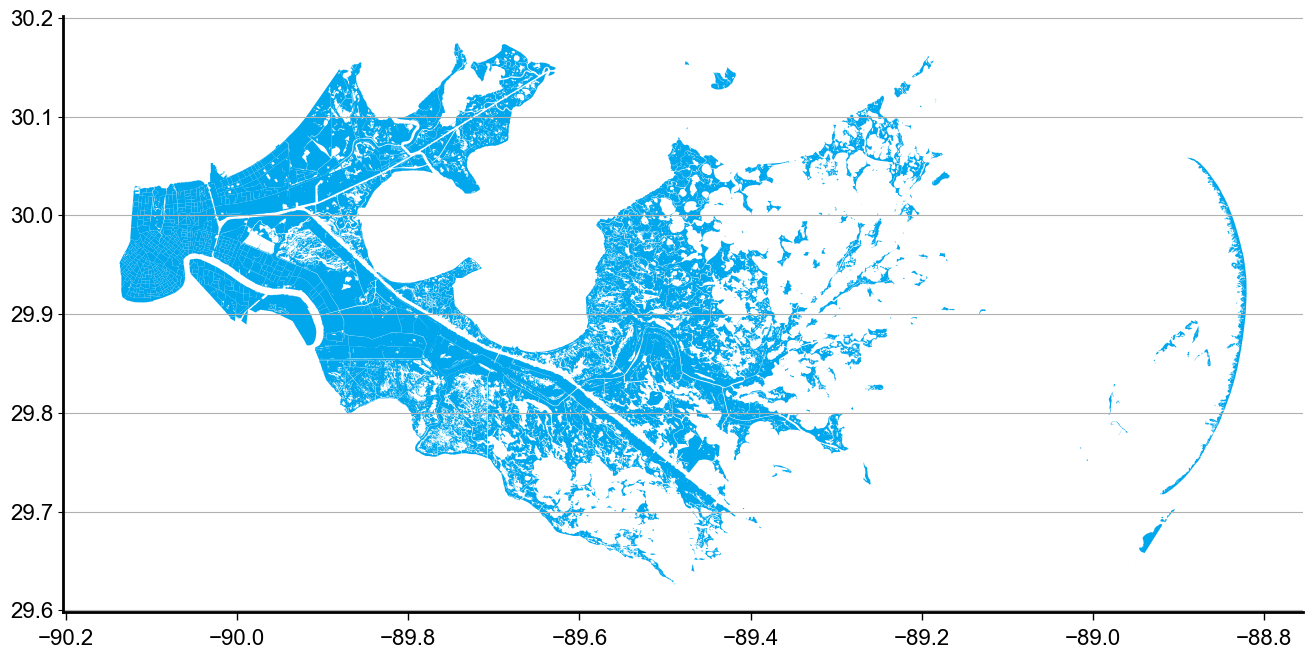

In [55]:
rh_bg_all[rh_bg_all['CNTYIDFP00'].isin(['22071', '22087'])].plot()

In [53]:
rh_bg_all[rh_bg_all['CNTYIDFP00'].isin(['22071', '22087'])][['geometry', 'uncovered_percent', 'uncovered_mean', 'damage_mean', 'grant_insurance_mean', 'hh_median_income', 'white_percent']].to_file('processed data/interactive_geojson_test.geojson')

59940